# How to run the QAOA algorithm on Hardware

This tutorial completes the workflow presented in tutorial #1 and runs the QAOA minimization using the primitives.

## Pre-Requisites

Let's define our problem, build and optimize our QAOA ansatz following the steps shown in tutorial 1.

### 1. Load hamiltonian from remapped graph (SAT mapping already applied)

In [1]:
import json
from qiskit.quantum_info import SparsePauliOp

graph_file = "data/graph_2layers_0seed.json"
data = json.load(open(graph_file, "r"))

pauli_list = data["paulis"]
qaoa_hamiltonian = SparsePauliOp.from_list(pauli_list)
print(qaoa_hamiltonian)

num_qubits = qaoa_hamiltonian.num_qubits

SparsePauliOp(['IIIIIZZIII', 'IIIIIIZIZI', 'IIIIIIZIIZ', 'ZIIIIZIIII', 'IIIIZZIIII', 'IIZIIIIZII', 'IZZIIIIIII', 'IIZZIIIIII', 'IIIIIIIZZI', 'IIIIZIIZII', 'IIIIZIIIIZ', 'IIIIIIIIZZ', 'ZZIIIIIIII', 'IZIZIIIIII', 'ZIIZIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


### 2. Choose swap strategy and build QAOA ansatz

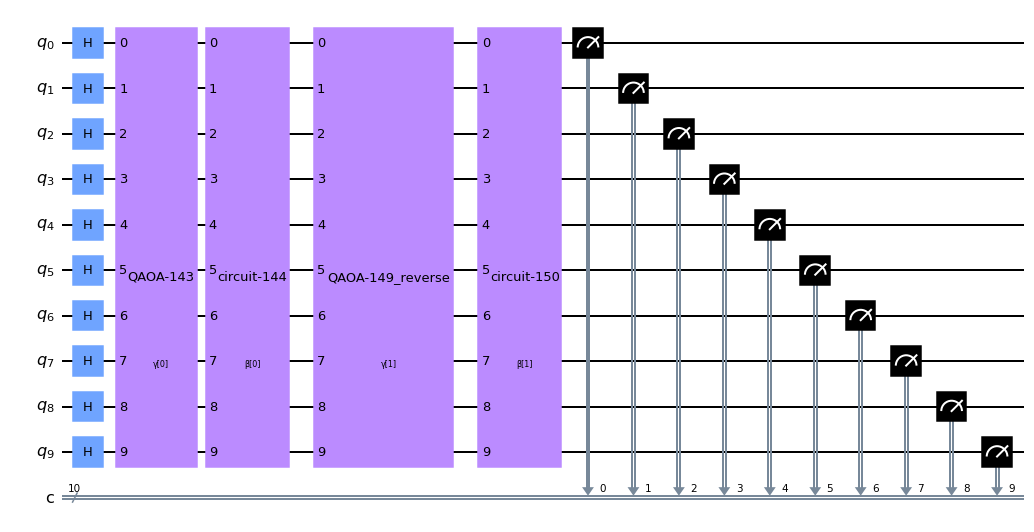

In [2]:
from qopt_best_practices.swap_strategies import create_qaoa_swap_circuit
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import SwapStrategy

swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])

# we define the edge_coloring map so that RZZGates are positioned next to SWAP gates to exploit CX cancellations
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(num_qubits)}

qaoa_circ = create_qaoa_swap_circuit(
    qaoa_hamiltonian, swap_strategy, edge_coloring, qaoa_layers=2
)

qaoa_circ.draw("mpl")

### 3. Select initial layout for backend

We are going to work with a fake provider in this case:

In [3]:
from qiskit.providers.fake_provider import FakeGuadalupe

backend = FakeGuadalupe()

In [4]:
from qopt_best_practices.qubit_selection import BackendEvaluator

path_finder = BackendEvaluator(backend)

path, fidelity, num_subsets = path_finder.evaluate(num_qubits)
print("Best path: ", path)
print("Best path fidelity", fidelity)

Best path:  [1, 4, 7, 10, 12, 13, 14, 11, 8, 5]
Best path fidelity 0.9099375156097996


In [5]:
from qiskit.transpiler import Layout

initial_layout = Layout.from_intlist(path, qaoa_circ.qregs[0])  # needs qaoa_circ

### 4. Transpile circuit

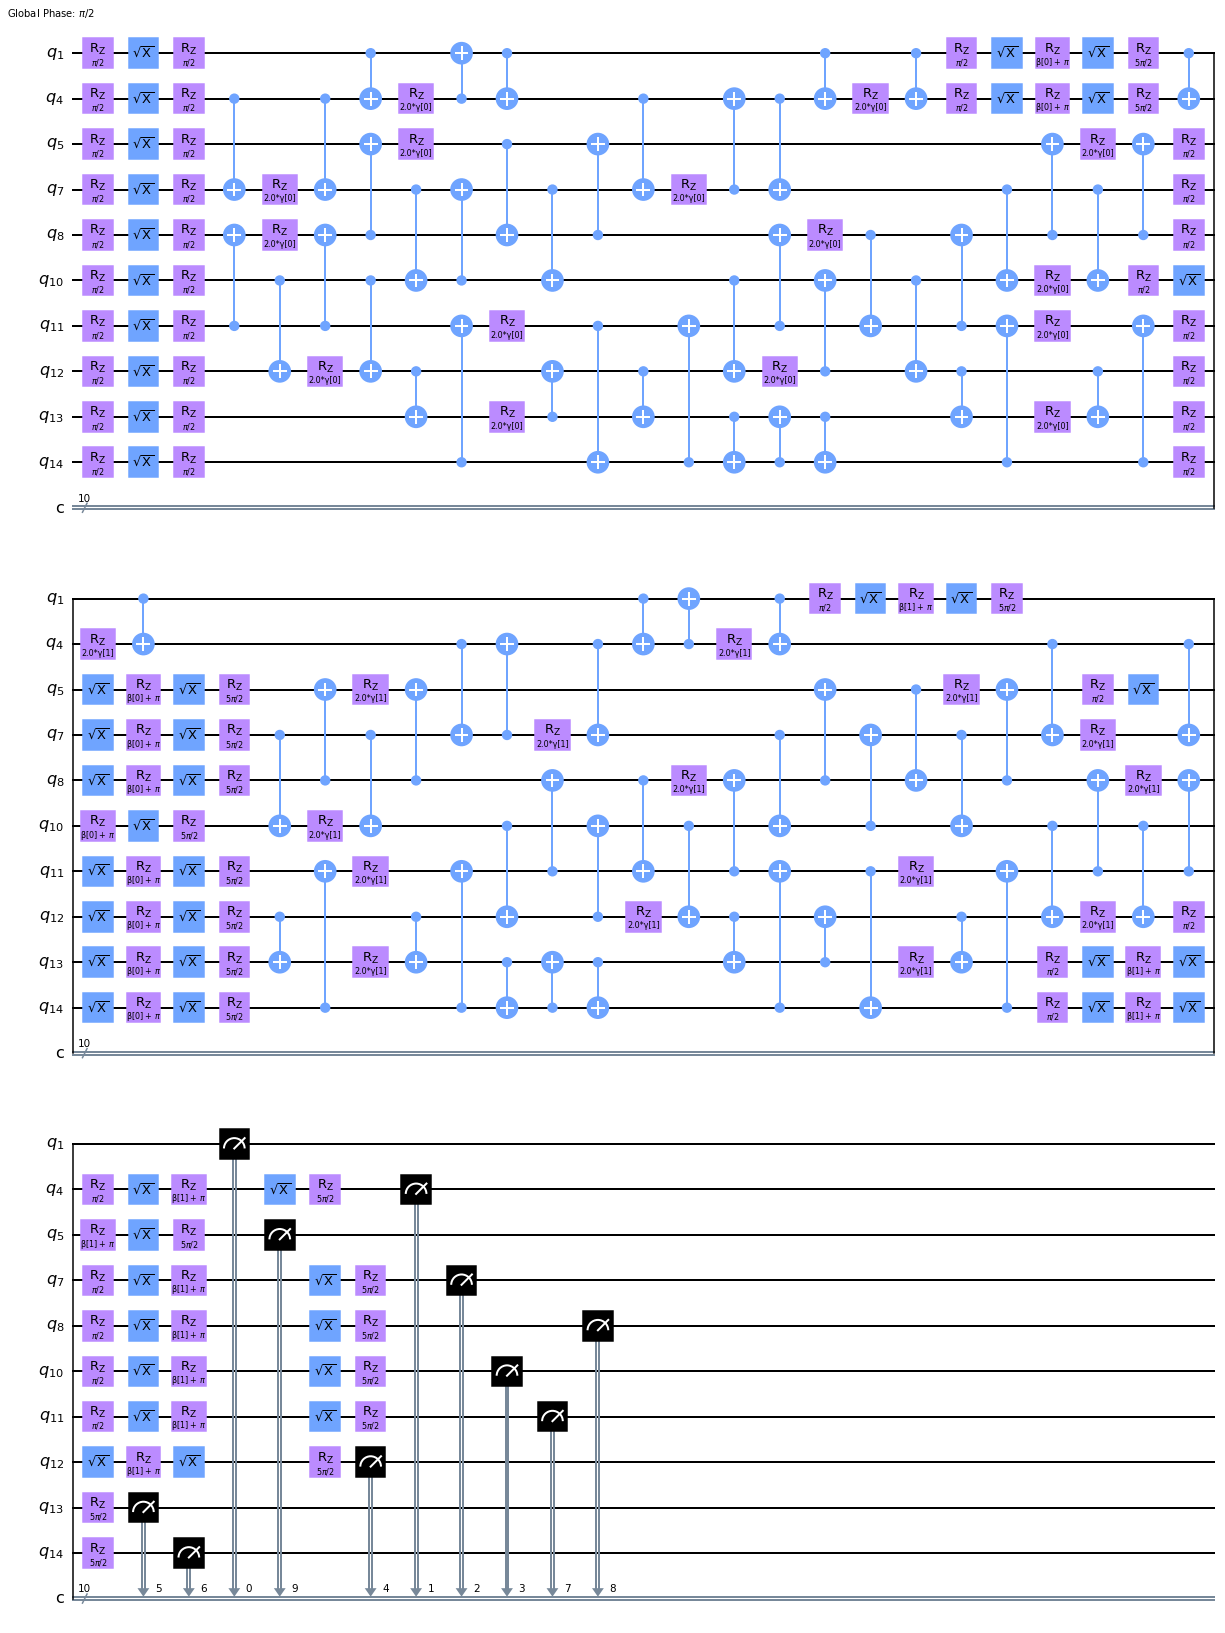

In [6]:
from qiskit.transpiler import CouplingMap, PassManager
from qiskit.transpiler.passes import (
    FullAncillaAllocation,
    EnlargeWithAncilla,
    ApplyLayout,
    SetLayout,
)

from qiskit import transpile

basis_gates = ["rz", "sx", "x", "cx"]

backend_cmap = CouplingMap(backend.configuration().coupling_map)

pass_manager_post = PassManager(
    [
        SetLayout(initial_layout),
        FullAncillaAllocation(backend_cmap),
        EnlargeWithAncilla(),
        ApplyLayout(),
    ]
)

# Map to initial_layout and finally enlarge with ancilla.
qaoa_circ = pass_manager_post.run(qaoa_circ)

# Now transpile to sx, rz, x, cx basis
qaoa_circ = transpile(qaoa_circ, basis_gates=basis_gates)
qaoa_circ.draw("mpl", idle_wires=False)

# Define and run QAOA algorithm using the Sampler primitive

### 1. Define Sampler

Because we are using a fake provider in this example, we will pick a Backend Sampler, but this cell can be replaced with any sampler configuration of your choice. It is important, though, to remember to **skip transpilation** during our sampler execution.

In [7]:
from qiskit.primitives import BackendSampler

sampler = BackendSampler(backend=backend, skip_transpilation=True)

### 2. Define Cost Function

The QAOA cost function using the Sampler requires the manual computation of the expectation values from the measurement results. For this means, we use the `evaluate_sparse_pauli` helper function.

In [8]:
from qopt_best_practices.cost_function import evaluate_sparse_pauli


def cost_func_sampler(params, ansatz, hamiltonian, sampler):

    job = sampler.run(ansatz, params)
    sampler_result = job.result()
    sampled = sampler_result.quasi_dists[0]

    # a dictionary containing: {state: (measurement probability, value)}
    evaluated = {
        state: (probability, evaluate_sparse_pauli(state, hamiltonian))
        for state, probability in sampled.items()
    }

    result = sum(probability * value for probability, value in evaluated.values())

    return result

### 3. Define Initial Point

In this example, we use the TQA initialization technique to improve our optimization:

In [9]:
import numpy as np

# TQA initialization parameters
dt = 0.75
p = 2  # 2 qaoa layers
grid = np.arange(1, p + 1) - 0.5
init_params = np.concatenate((1 - grid * dt / p, grid * dt / p))
print(init_params)

[0.8125 0.4375 0.1875 0.5625]


### 4. Run optimization

In [10]:
from scipy.optimize import minimize

res = minimize(
    cost_func_sampler,
    init_params,
    args=(qaoa_circ, qaoa_hamiltonian, sampler),
    method="COBYLA",
)
print(res)

/opt/anaconda3/envs/new-tutorials/lib/python3.9/site-packages/scipy/optimize/_cobyla_py.py:285: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.701171875
       x: [ 2.196e+00  1.540e+00  1.884e+00 -8.475e-02]
    nfev: 53
   maxcv: 0.0


### 5. Sample best result

In [15]:
from qiskit.visualization import plot_distribution

qc = qaoa_circ.assign_parameters(res.x)
samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]
print(samp_dist)

{1013: 0.0001, 503: 0.0001, 1019: 0.0001, 160: 0.0001, 767: 0.0001, 11: 0.0001, 313: 0.0001, 189: 0.0001, 4: 0.0002, 3: 0.0001, 959: 0.0001, 175: 0.0001, 961: 0.0001, 719: 0.0002, 962: 0.0001, 61: 0.0001, 25: 0.0002, 68: 0.0001, 768: 0.0001, 1007: 0.0001, 900: 0.0001, 955: 0.0001, 864: 0.0001, 74: 0.0002, 422: 0.0003, 14: 0.0003, 761: 0.0003, 543: 0.0001, 603: 0.0002, 811: 0.0001, 36: 0.0001, 759: 0.0003, 561: 0.0002, 975: 0.0001, 564: 0.0002, 315: 0.0001, 140: 0.0006, 551: 0.0003, 1016: 0.0002, 129: 0.0001, 671: 0.0004, 204: 0.0006, 49: 0.0001, 199: 0.0003, 982: 0.0001, 142: 0.0003, 192: 0.0002, 464: 0.0002, 264: 0.0001, 997: 0.0002, 806: 0.0008, 150: 0.0008, 507: 0.0003, 45: 0.0001, 826: 0.0004, 511: 0.0003, 843: 0.0001, 916: 0.0003, 32: 0.0001, 135: 0.0002, 895: 0.0002, 487: 0.0001, 388: 0.0002, 625: 0.0002, 601: 0.0002, 79: 0.0003, 846: 0.0004, 656: 0.0006, 474: 0.0005, 528: 0.0002, 436: 0.0003, 317: 0.0007, 984: 0.0002, 720: 0.0003, 823: 0.0001, 187: 0.0003, 824: 0.0004, 758: 0.00

In [11]:
# from qiskit_algorithms import SamplingVQE
# from qiskit_algorithms.optimizers import COBYLA
#
# optimizer = COBYLA()
# qaoa = SamplingVQE(sampler, ansatz=qaoa_circ, optimizer=optimizer)
# result = qaoa.compute_minimum_eigenvalue(cost_operator)
# print(result)
